In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import dates
from matplotlib.colors import LogNorm
from netCDF4 import num2date,date2num,Dataset
import matplotlib._pylab_helpers
#from joblib import Parallel, delayed
import scipy.interpolate as interpolate
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats.mstats import scoreatpercentile
import pyart
import os,subprocess,time,copy
import scipy
import math
import matplotlib.gridspec as gridspec
import cPickle as pickle
#import pickle
import pprint
import pyproj
import pandas as pd
import scipy.interpolate as interpolate
import sharppy.sharptab as tab
from marcus_py_tools import make_edge_vec, xy_from_latlon, latlon_from_xy, walklevel, find_stuff_at_level
%matplotlib inline

###Load Data

In [62]:
#..
#filenm = '/mnt/raid/afridlin/data/mc3e/citation-mcfarquhar/mc3e.illinois_microphysics.110520_V3.cdf'
#filenm = '/mnt/raid/afridlin/data/mc3e/citation-mcfarquhar/mc3e.illinois_microphysics.110520_V5a.cdf'
#filenm = '/mnt/raid/afridlin/data/mc3e/citation-mcfarquhar/mc3e.illinois_microphysics.110520_V5b.cdf'
filenm = '/mnt/raid/afridlin/data/mc3e/citation-mcfarquhar/mc3e.illinois_microphysics.110520_V3withArea.cdf'
nc     = Dataset(filenm,'r')
timm   = nc.variables['time'][:]      #..HHMMSS
d_le   = nc.variables['bin_min'][:]   #..In microns
d_re   = nc.variables['bin_max'][:]
d_mid  = nc.variables['bin_mid'][:]
dD     = nc.variables['bin_dD'][:]/(1.e4)  #..1/um -> 1/cm
dN_dD  = nc.variables['numdist'][:,:]   #..1/cm4
dM_dD  = nc.variables['massdist'][:,:]  #..g/cm4
dM_dD_a = nc.variables['massdist_BL'][:,:] #..Using Baker and Lawson
dA_dD  = nc.variables['areadist'][:,:]  #..cm2/cm4
nc.close()
#..Convert timm to a less esoteric format, in this case decimal UTC hour of day
ntim   = timm.shape[0]
time   = []
for i in range(ntim):
    timst = str(timm[i])
    time  = np.r_[time,float(timst[:2]) + float(timst[2:4])/60. + float(timst[4:])/3600.]
#..
nbin   = d_mid.shape[0]
dlogD  = np.log10(d_re/d_le)
#..
cita_leg0_s = 13.8964   #
cita_leg0_e = 14.0050   #
cita_leg1_s = 14.0358      #
cita_leg1_e = 14.2197      #
cita_leg2_s = 14.2644         #
cita_leg2_e = 14.5422         #
cita_leg3_s = 14.5839      #
cita_leg3_e = 14.6961      #
cita_leg4_s = 14.7292   #
cita_leg4_e = 14.9047   #
#..
#..

###Chop and plot dN/dlogD for top leg

1000


(50, 10000)

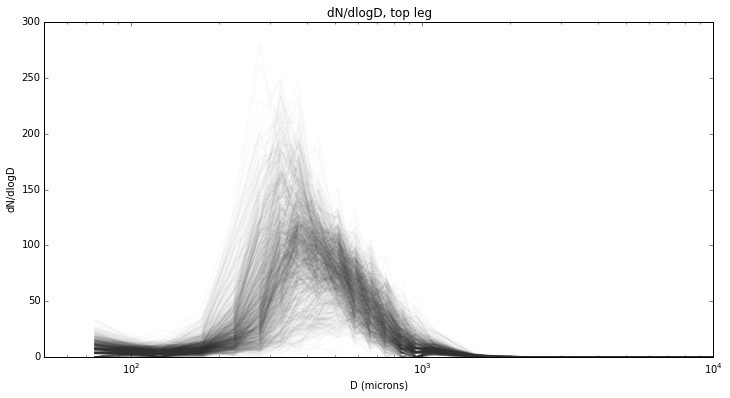

In [63]:
#..Just for the halibut, let's look at PSD at the top (leg2)
logcon    = np.logical_and(time>cita_leg2_s,time<cita_leg2_e)
tim_cut   = time[logcon]
dN_dD_cut = dN_dD[logcon,:]
tnum      = tim_cut.shape[0]
print tnum
fig = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(111)
for i in range(tnum):
    ax.semilogx(d_mid,dN_dD_cut[i,:]*dD*1.e3/dlogD,'k-',alpha=.02,lw=2)
plt.title('dN/dlogD, top leg')
ax.set_xlabel('D (microns)')
ax.set_ylabel('dN/dlogD')
ax.set_xlim(50,10000)

75.0 27500.0


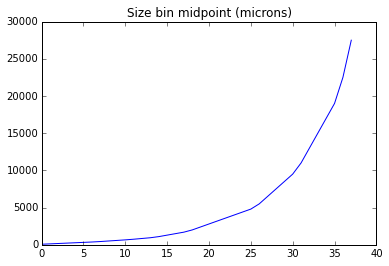

In [64]:
plt.plot(d_mid)
plt.title('Size bin midpoint (microns)')
print d_mid[0],d_mid[-1]

###Now look into fall speeds for each size bin
To do this, do we cacalate velocity of bin midpoint, or (linear) average of velocity across the bin, or reflectivity-weighted average across the bin? The last option would seem to be the most defensible, but would weight the average towards the characteristics of the upper edge of the bin. In any case, one hopes the bin resolution is sufficient to make these effects relatively minor. 

Actually, I just realized that the second and third approaches are unlikely to be feasible, since area is likely only reported for bin center. Trying to figure out what the other approaches would produce would be a poor use of time. 

Now, for each size bin at each time, mass/number and area/number vary. Therefore, for each mass bin for each time, terminal fall speed must be cacalated independently.

In [83]:
#..Constants
grav = 981.       #..cm/s2
rhoa = 3.591e-4   #..g/cm3    REPLACE THIS WITH DHARMA VALS!
eta  = 1.511e-4   #..g/cm/s dynamic viscosity
nu   = eta/rhoa   #..cgs
del0 = 8.         #..constant from Heymsfield and Westbrook
c0   = 0.35
#..Loop over dimensions of data
num_bin = dN_dD.shape[1]
num_tim = dN_dD.shape[0]
print num_bin,num_tim
#..Cacalate the area of a sphere and particle average area for each bin,time
area_sphere = ((d_mid/1.e4)**2)/4.  #..in cm2
area_part   = dA_dD/dN_dD
mass_part   = dM_dD/dN_dD
area_ratio  = np.ones_like(area_part)
for i in range(num_tim):
    area_ratio[i,:] = area_part[i,:]/area_sphere[:]
#..Now do all the cacalations
v_fall = np.zeros(area_part.shape)
for i in range(num_tim):
    for j in range(num_bin):
        chi_heym = rhoa/eta**2 * 8.*mass_part[i,j]*grav/(np.pi*np.sqrt(area_ratio[i,j]))
        rey_heym = del0**2/4 * (np.sqrt(1.+4.*np.sqrt(chi_heym)/(del0**2*np.sqrt(c0)))-1.)**2
        v_fall[i,j] = eta*rey_heym/(rhoa*d_mid[j]/1.e4)/100.  #..m/s
#..

38 14925


###Calculate radar Doppler spectra
For some given radar frequency, Tipp, etc... calculate Doppler spectra. Assumptions used are:

In [ ]:
#..Radar constants (NOAA SGP S-band)
freq     = 2835.e6
tipp     = 136.e-6
Ncoh     = 12
Npts     = 256
#..Radar constants (ARM SGP KAZR)

#..
fNyquist = .5*(1./(tipp*Ncoh))
delta_f  = 2.*fNyquist/Npts
rlambda  = (2.99792458e8)/freq
f_range  = []
for i in range(Npts):
    f_range = np.r_[f_range,(i-Npts/2)*delta_f]
Vd       = f_range*rlambda/2.
#..


<matplotlib.colorbar.Colorbar instance at 0x7fb5906e3200>

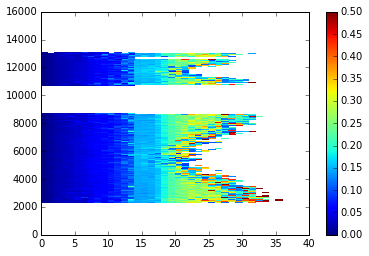

In [86]:
vt = np.ma.masked_where(np.isnan(v_fall),v_fall)
plt.pcolormesh(vt,vmin=0,vmax=.5)
plt.colorbar()

(38,)


<matplotlib.colorbar.Colorbar instance at 0x7fb58f6a0248>

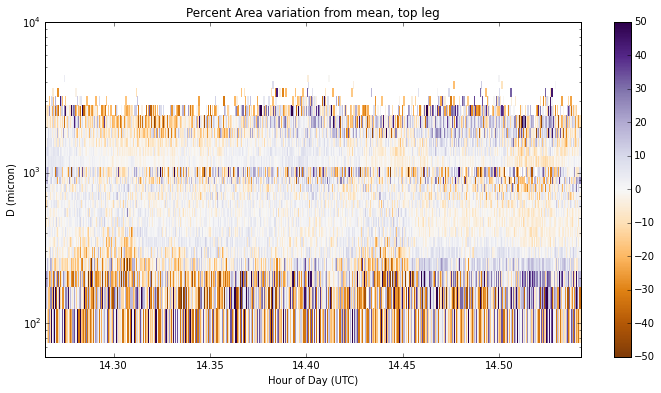

In [66]:
#..Let's think about how to do this. For each size bin, there is a total area for each time...
#..The question is:  is the ratio of dA/dD to dN/dD constant? let us look: ... simple answer: NO
#..The reason for this is A is determined based on observed particle properties. These vary (semi)-independently 
#..of size... so... there. 
dum = dA_dD/dN_dD
ratio = dum[logcon,:]
ratio[ratio<0.] = np.nan
ratiof = np.ma.masked_where(np.isnan(ratio),ratio)
ratio_m = ratiof.mean(axis=0)
for i in range(num_bin):
    ratiof[:,i] = (ratiof[:,i]-ratio_m[i])/ratio_m[i]
print ratio_m.shape
fig = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(111)
plt.pcolormesh(time[logcon],d_mid,ratiof.T*100.,vmin=-50,vmax=50,cmap=cm.PuOr)
plt.yscale('log')
ax.set_xlim(cita_leg2_s,cita_leg2_e)
ax.set_ylim(60,10000)
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('D (micron)')
plt.title('Percent Area variation from mean, top leg')
plt.colorbar()

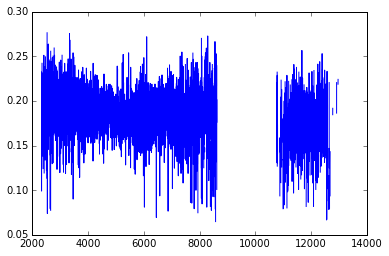

In [43]:
plt.plot(ratio[:,10])